# Crypto Clustering

**Mục tiêu:** Phân cụm mã crypto dựa trên **hành vi thống kê**
từ dữ liệu dạng **panel time-series không đều**.

**Pipeline:**
1. Nạp dữ liệu đã tiền xử lý (`processed_cryptotocurrency.csv`), chuẩn hóa `timestamp`.
2. Thống kê chất lượng chuỗi cho mỗi `symbol` (số điểm, độ phủ, khoảng cách thời gian).
3. Lọc các mã có chuỗi đủ dài/dày để đặc trưng ổn định.
4. Tạo vector đặc trưng cho từng `symbol` (price/return/volume/marketcap + skew/kurtosis + autocorr).
5. Chuẩn hóa, giảm chiều bằng PCA; chọn số cụm bằng silhouette score.
6. Phân cụm (KMeans), trực quan hóa và mô tả cụm.

## 1) Import thư viện & thiết lập chung

In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import iqr, zscore
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
print("Libraries imported.")

Libraries imported.


## 2) Nạp dữ liệu & chuẩn hóa thời gian

In [360]:
DATA_PATH = 'processed_cryptotocurrency.csv'
df = pd.read_csv(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['timestamp']).sort_values(['symbol','timestamp']).reset_index(drop=True)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Dải thời gian:", df['timestamp'].min(), "→", df['timestamp'].max())
print("Số mã duy nhất:", df['name_encoded'].nunique())
print(df.head(10))

Shape: (170430, 10)
Columns: ['timestamp', 'name', 'symbol', 'price_usd', 'vol_24h', 'total_vol', 'chg_24h', 'chg_7d', 'market_cap', 'name_encoded']
Dải thời gian: 2025-01-04 00:34:00 → 2025-12-10 23:52:00
Số mã duy nhất: 266
            timestamp   name symbol  price_usd      vol_24h  total_vol  \
0 2025-04-10 10:36:00     0G     0g       3.07  328906282.0     0.0010   
1 2025-04-10 10:39:00     0G     0g       3.07  326561005.0     0.0009   
2 2025-04-10 10:52:00     0G     0g       3.05  219867828.0     0.0006   
3 2025-04-10 11:26:00     0G     0g       3.05  215138181.0     0.0006   
4 2025-04-10 11:43:00     0G     0g       3.04  313025756.0     0.0009   
5 2025-04-10 11:55:00     0G     0g       3.04  213275758.0     0.0006   
6 2025-04-10 10:36:00  1INCH  1inch       0.27   20665604.0     0.0001   
7 2025-04-10 10:39:00  1INCH  1inch       0.26   21171651.0     0.0001   
8 2025-04-10 10:52:00  1INCH  1inch       0.26   21266382.0     0.0001   
9 2025-04-10 11:26:00  1INCH  1inc

## 3) Đánh giá chất lượng chuỗi theo từng mã

In [361]:
def quality_stats(group):
    t = group['timestamp'].values
    n = len(t)
    if n < 3:
        return pd.Series({'n_obs': n, 'span_days': 0, 'median_step_min': np.nan,
                          'iqr_over_median': np.nan, 'coverage': 0.0, 'max_gap_h': np.nan})
    dt = np.diff(t).astype('timedelta64[m]').astype(float)
    med = np.nanmedian(dt) if len(dt)>0 else np.nan
    iqr = (np.nanpercentile(dt, 75) - np.nanpercentile(dt, 25)) if len(dt)>0 else np.nan
    span_min = (t[-1] - t[0]).astype('timedelta64[m]').astype(float)
    expected = (span_min / med) if (med and med>0) else np.nan
    coverage = (n / expected) if (expected and expected>0) else np.nan
    max_gap_h = (np.nanmax(dt)/60.0) if len(dt)>0 else np.nan
    span_days = span_min / (60*24) if span_min else 0
    return pd.Series({
        'n_obs': n,
        'span_days': span_days,
        'median_step_min': med,
        'iqr_over_median': (iqr/med) if (med and med>0) else np.nan,
        'coverage': coverage,
        'max_gap_h': max_gap_h
    })

qs = df.groupby('name_encoded').apply(quality_stats).reset_index()
qs = qs.sort_values('n_obs', ascending=False).reset_index(drop=True)

print("Quality stats (top 10 by n_obs):")
print(qs.head(10))
print("\nTóm tắt:")
print(qs.describe(include='all'))

Quality stats (top 10 by n_obs):
   name_encoded   n_obs   span_days  median_step_min  iqr_over_median  \
0           226  6319.0  340.970833             60.0         0.483333   
1           187  6319.0  340.970833             60.0         0.483333   
2           199  6318.0  340.970833             60.0         0.483333   
3           253  6318.0  340.970833             60.0         0.483333   
4            66  6317.0  340.970833             60.0         0.483333   
5            76  6317.0  340.970833             60.0         0.483333   
6           210  6317.0  340.970833             60.0         0.483333   
7           201  6315.0  340.970833             60.0         0.483333   
8            26  6315.0  340.970833             60.0         0.483333   
9            48  6315.0  340.970833             60.0         0.483333   

   coverage  max_gap_h  
0  0.772182     720.45  
1  0.772182     720.45  
2  0.772060     720.45  
3  0.772060     720.45  
4  0.771938     720.45  
5  0.771938  

## 4) Lọc các mã đủ chuẩn

In [362]:
MIN_SPAN_DAYS = 60
MIN_COVERAGE = 0.5
MAX_IQR_OVER_MED = 1.0
MAX_GAP_H = 1000

mask = (
    (qs['span_days'] >= MIN_SPAN_DAYS) &
    (qs['coverage'] >= MIN_COVERAGE) &
    (qs['iqr_over_median'] <= MAX_IQR_OVER_MED) &
    (qs['max_gap_h'] <= MAX_GAP_H)
)

ok_syms = qs.loc[mask, 'name_encoded'].tolist()
print(f"Số đồng crypto đạt chuẩn: {len(ok_syms)} / {qs['name_encoded'].nunique()}")
print("Danh sách các đồng crypto đạt chuẩn:", ok_syms[:])

df_ok = df[df['name_encoded'].isin(ok_syms)].copy()
print("Shape sau lọc dữ liệu:", df_ok.shape)

Số đồng crypto đạt chuẩn: 20 / 266
Danh sách các đồng crypto đạt chuẩn: [226, 187, 199, 253, 66, 76, 210, 201, 26, 48, 36, 21, 45, 98, 37, 100, 214, 219, 184, 223]
Shape sau lọc dữ liệu: (117784, 10)


## 5) Biến mỗi coin thành **một vector đặc trưng**

In [363]:
# --- Tiền xử lý: thêm các cột log để giảm ảnh hưởng outlier ---
df_ok['price_usd_log'] = np.log1p(df_ok['price_usd'])
df_ok['vol_24h_log'] = np.log1p(df_ok['vol_24h'])
df_ok['market_cap_log'] = np.log1p(df_ok['market_cap'])


# --- Hàm tạo vector đặc trưng (đã loại bỏ feature tương quan cao) ---
def summarize_coin(g):
    g = g.sort_values('timestamp')
    price = np.log1p(g['price_usd'])
    vol = np.log1p(g['vol_24h'])
    mcap = np.log1p(g['market_cap'])
    chg24 = g['chg_24h']
    chg7 = g['chg_7d']
    ret = price.pct_change().dropna()

    def safe_autocorr(x, lag):
        return x.autocorr(lag=lag) if len(x) > lag + 1 else np.nan

    def safe_kurt(x):
        return x.kurtosis() if len(x.dropna()) > 2 else np.nan

    return pd.Series({
        # Giá
        'price_mean': price.mean(),
        'price_std': price.std(),
        'price_skew': price.skew(),
        'price_kurt': safe_kurt(price),

        # Lợi nhuận
        'return_mean': ret.mean(),
        'return_std': ret.std(),
        'return_skew': ret.skew(),

        # Khối lượng & vốn hóa
        'vol_mean': vol.mean(),
        'vol_std': vol.std(),
        'chg7_std': chg7.std(),
        'mcap_mean': mcap.mean(),
        'volume_to_marketcap': (vol / (mcap + 1e-6)).mean(),

        # Autocorrelation
        'autocorr_lag1': safe_autocorr(price, 1),
        'autocorr_lag2': safe_autocorr(price, 2),
        'autocorr_vol_lag1': safe_autocorr(vol, 1)
    })


# --- Tạo đặc trưng cho từng coin ---
features = df_ok.groupby('name_encoded').apply(summarize_coin)
features = features.replace([np.inf, -np.inf], np.nan).dropna()

print("Tạo đặc trưng thành công. Shape:", features.shape)
print(features.head(10))


Tạo đặc trưng thành công. Shape: (19, 15)
              price_mean  price_std  price_skew  price_kurt  return_mean  \
name_encoded                                                               
21              3.156831   0.165974    0.668012   -0.118971     0.000035   
26              6.685940   0.252472    0.417230   -1.238061     0.000027   
36             11.576383   0.113585   -1.158199    0.389929     0.000006   
37              6.198404   0.181237   -0.823654   -0.238972     0.000023   
45              0.548777   0.058626    0.117164   -0.979243     0.000136   
48              2.902715   0.208842    0.185120   -1.159393     0.000068   
66              0.186921   0.027725    0.304438   -0.801031     0.000262   
76              8.035235   0.350054   -0.496179   -1.159055     0.000032   
98              0.184534   0.028081    0.383626   -0.963211     0.000360   
100             3.713413   0.220081   -1.275012    1.898256     0.000115   

              return_std  return_skew   vol_m

## 6) Chuẩn hóa và giảm chiều bằng PCA

PCA explained variance ratio: [0.34286282 0.24505221 0.14478192 0.08993333 0.06121335]


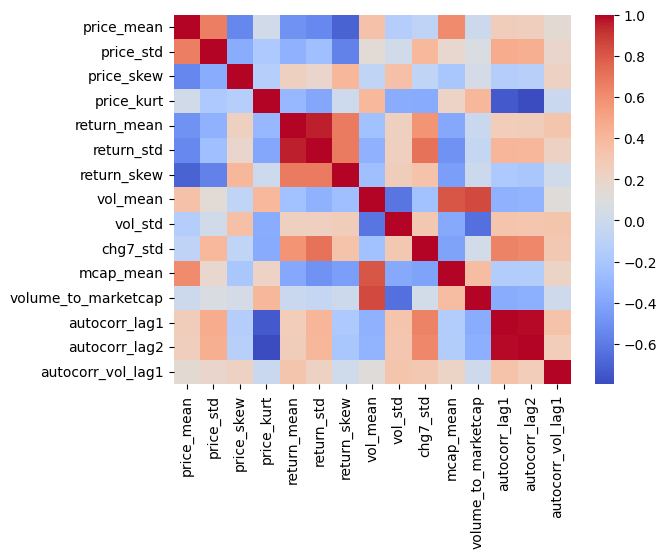

In [364]:
sns.heatmap(features.corr(), cmap='coolwarm', annot=False)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

## 7) Chọn số cụm và phân cụm bằng KMeans

In [365]:
sil = []
K = range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled, labels))

best_k = K[sil.index(max(sil))]
print("Best k =", best_k)

Best k = 3


In [366]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)
features['cluster'] = labels

## 8) Trực quan hóa các cụm trên không gian PCA 2D

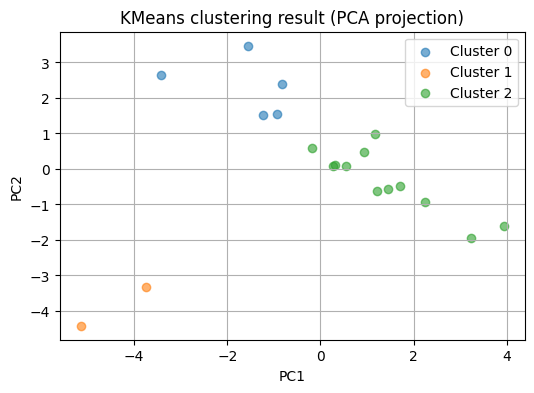

In [367]:
plt.figure(figsize=(6,4))
for i in range(best_k):
    idx = (labels == i)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f'Cluster {i}', alpha=0.6)
plt.title("KMeans clustering result (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

Trung bình đặc trưng theo từng cụm:


,price_mean,price_std,price_skew,price_kurt,return_mean,return_std,return_skew,vol_mean,vol_std,chg7_std,mcap_mean,volume_to_marketcap,autocorr_lag1,autocorr_lag2,autocorr_vol_lag1
cluster,,,,,,,,,,,,,,,
0,7.532,0.218,-0.459,-0.567,0.0,0.004,-8.682,22.474,0.494,0.082,25.745,0.873,0.990,0.980,0.982
1,0.693,0.000,0.271,2.066,0.0,0.000,0.455,24.190,0.425,0.000,25.352,0.954,0.949,0.915,0.961
2,1.467,0.100,-0.014,-0.677,0.0,0.015,1.003,19.838,0.577,0.108,23.490,0.844,0.988,0.977,0.981



 Số coin trong mỗi cụm:
cluster
0     5
1     2
2    12
Name: count, dtype: int64


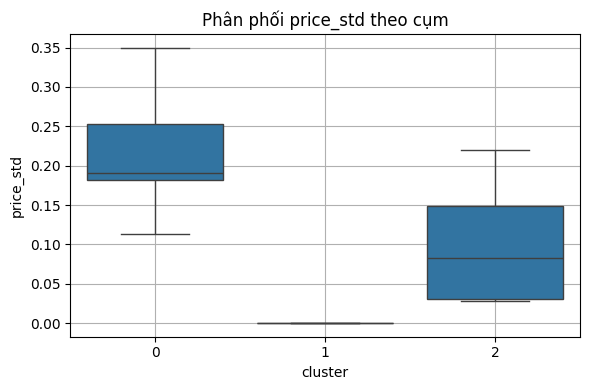

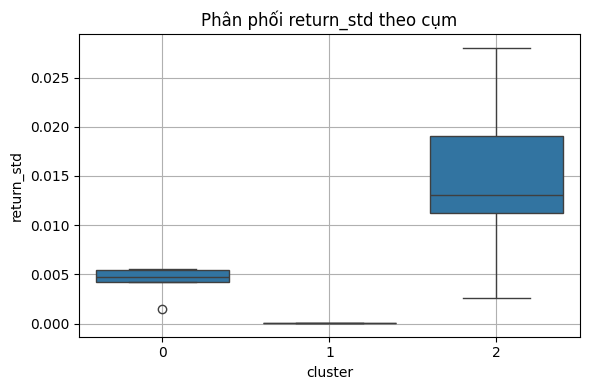

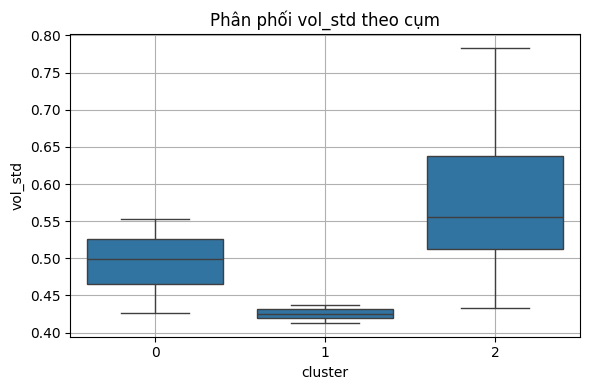

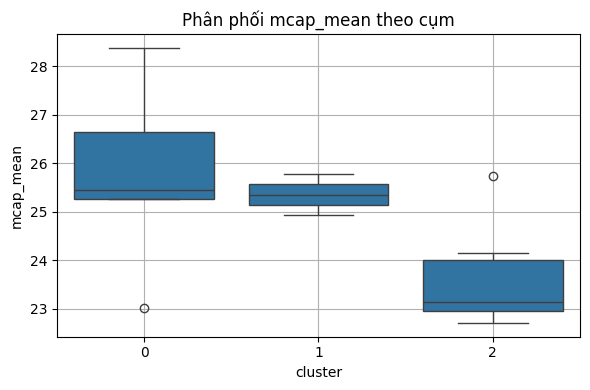

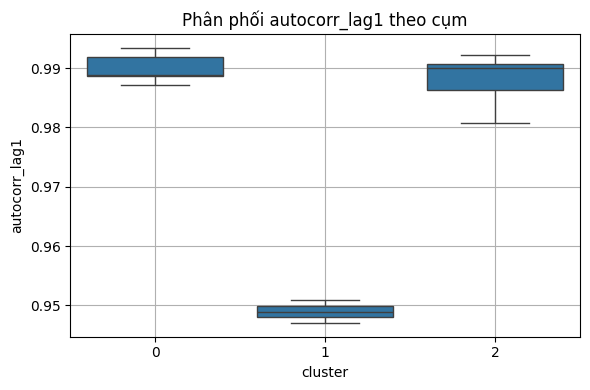

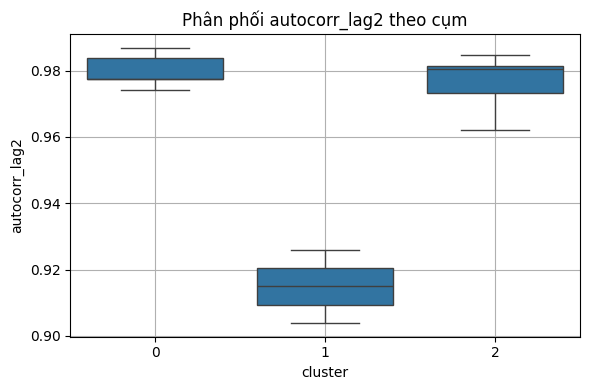

In [368]:
# Mô tả thống kê các đặc trưng theo từng cụm
cluster_profiles = features.groupby('cluster').mean().round(3)
print("Trung bình đặc trưng theo từng cụm:")
display(cluster_profiles)

# Thống kê số lượng coin trong mỗi cụm
print("\n Số coin trong mỗi cụm:")
print(features['cluster'].value_counts().sort_index())

# Vẽ boxplot cho một số đặc trưng chính
import seaborn as sns

key_features = ['price_std', 'return_std', 'vol_std', 'mcap_mean', 'autocorr_lag1', 'autocorr_lag2']
for feat in key_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=features, x='cluster', y=feat)
    plt.title(f'Phân phối {feat} theo cụm')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
